# Year Concept Disruption Evaluation & Analysis

This notebook:
1. **Evaluates** existing unlearned models on year concept understanding (ordering, arithmetic, classification)
2. **Visualizes** disruption across LoRA ranks
3. **Analyzes** correlation between LoRA rank and disruption magnitude

## Workflow

1. Generate models using `pipeline.py` (year concept evaluation is NOT run during pipeline)
2. Run this notebook to evaluate and visualize year concept disruption on existing models


In [1]:
import os
import sys
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Optional, List, Dict, Any
from datetime import datetime, timezone
from zoneinfo import ZoneInfo
import torch
import ray
from transformers import AutoModelForCausalLM, AutoTokenizer
from utils.attention_backend import get_attn_implementation

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd()))

from pipeline import write_year_concept_csv

# Configuration
RESULTS_DIR = "evals/pipeline/year_concept"
OUTPUT_DIR = "figures/year_concept"  # Directory to save plots
DATA_ROOT = "data"
YEAR_CONCEPT_DATA_FILE = "year_concept_eval/year_concept.jsonl"

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Initialize Ray (will be done in evaluation cell)
# ray.init(num_gpus=1)  # Uncomment if needed


## 1. Define Evaluation Function

First, we define the Ray remote function for evaluating models on the year concept dataset.


In [2]:
doc_to_choice = ["A", "B", "C", "D"]


def get_current_time():
    """Get current time in SF timezone."""
    sf_tz = ZoneInfo("America/Los_Angeles")
    return datetime.now(sf_tz)


@ray.remote(num_gpus=1)
def evaluate_year_concept(
    model_path: str,
    data_file: str,
    data_root: str = "data",
    val_batch_size: int = 8,
    attn_backend: Optional[str] = None,
    base_model: Optional[str] = None,
    lora_rank: int = 0,
    max_seq_len: int = 512,
    checkpoint_type: str = "UNKNOWN",
) -> Dict[str, Any]:
    """Evaluate model on year concept understanding.
    
    Args:
        model_path: Path to model checkpoint (or model_id for baseline)
        data_file: Relative path to year concept evaluation dataset
        data_root: Root directory for data files
        val_batch_size: Batch size for evaluation
        attn_backend: Attention backend to use
        base_model: Base model ID (for baseline, same as model_path)
        lora_rank: LoRA rank (0 for baseline or full fine-tuning)
        max_seq_len: Maximum sequence length
        checkpoint_type: Checkpoint type ("BASELINE", "A", "B", "C")
    
    Returns:
        Dict with accuracy metrics and metadata
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model and tokenizer
    attn_impl = get_attn_implementation(attn_backend)
    
    # Check if model_path is a local checkpoint or HuggingFace model ID
    if os.path.exists(model_path) or os.path.isdir(model_path):
        # Local checkpoint
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.bfloat16,
            attn_implementation=attn_impl,
        ).to(device)
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        actual_base_model = base_model if base_model else model_path
    else:
        # HuggingFace model ID (baseline)
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.bfloat16,
            attn_implementation=attn_impl,
        ).to(device)
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        actual_base_model = model_path
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model.eval()
    
    # Get label token IDs for A, B, C, D
    label_possibilities = [
        tokenizer.encode(c, add_special_tokens=False)[-1]
        for c in doc_to_choice
    ]
    
    def create_prompt(point):
        return "\n".join(
            [point["question"]]
            + [f"{doc_to_choice[i]}. {c}" for i, c in enumerate(point["choices"])]
            + ["Answer:"]
        )
    
    def _data_path(rel_path: str, ext: str = ".jsonl") -> str:
        """Helper to resolve data path with data_root prefix."""
        if os.path.isabs(rel_path):
            base = rel_path
        else:
            base = os.path.join(data_root, rel_path)
        if ext and not base.endswith(ext):
            base += ext
        return base
    
    # Load year concept dataset
    file_path = _data_path(data_file)
    if not os.path.exists(file_path):
        raise FileNotFoundError(
            f"Year concept evaluation dataset not found: {file_path}\n"
            f"Please generate it first by running: python scripts/generate_year_concept_eval.py"
        )
    
    with open(file_path, 'r') as f:
        all_data = [json.loads(line) for line in f]
    
    if not all_data:
        raise ValueError(f"Year concept evaluation dataset is empty: {file_path}")
    
    # Categorize questions by type (for per-metric accuracy)
    ordering_data = []
    arithmetic_data = []
    classification_data = []
    boundary_data = []
    
    for point in all_data:
        question = point["question"].lower()
        if "earlier" in question or "later" in question:
            ordering_data.append(point)
        elif "plausibly a calendar year" in question or "calendar year" in question:
            boundary_data.append(point)
        elif "year is" in question or "years" in question or "equals" in question or "plus" in question or "minus" in question:
            arithmetic_data.append(point)
        elif "decade" in question or "century" in question:
            classification_data.append(point)
        else:
            # Default to arithmetic if unclear
            arithmetic_data.append(point)
    
    def evaluate_subset(data_subset, subset_name):
        """Evaluate a subset of questions."""
        if not data_subset:
            return 0.0, 0
        
        correct = 0
        total = len(data_subset)
        
        # Process in batches
        for i in range(0, total, val_batch_size):
            batch = data_subset[i:i + val_batch_size]
            prompts = [create_prompt(point) for point in batch]
            
            tokens = tokenizer(
                prompts, return_tensors="pt", max_length=max_seq_len,
                truncation=True, padding=True
            ).to(device)
            
            with torch.no_grad():
                outputs = model(**tokens)
                logits = outputs.logits[:, -1, :]  # Last token logits for each item
            
            # Get predictions among A, B, C, D
            for j, point in enumerate(batch):
                label_logits = logits[j, label_possibilities]
                pred = label_logits.argmax().item()
                
                if pred == point["answer"]:
                    correct += 1
        
        acc = correct / total if total > 0 else 0.0
        return acc, total
    
    # Validate question categorization
    total_categorized = len(ordering_data) + len(arithmetic_data) + len(classification_data) + len(boundary_data)
    if total_categorized != len(all_data):
        print(f"Warning: Question categorization mismatch. Total: {len(all_data)}, Categorized: {total_categorized}")
    
    # Log question counts for debugging
    print(f"Year concept evaluation question counts - Ordering: {len(ordering_data)}, "
          f"Arithmetic: {len(arithmetic_data)}, Classification: {len(classification_data)}, "
          f"Boundary: {len(boundary_data)}, Total: {len(all_data)}")
    
    # Evaluate each metric type
    ordering_acc, ordering_count = evaluate_subset(ordering_data, "ordering")
    arithmetic_acc, arithmetic_count = evaluate_subset(arithmetic_data, "arithmetic")
    classification_acc, classification_count = evaluate_subset(classification_data, "classification")
    boundary_acc, boundary_count = evaluate_subset(boundary_data, "boundary")
    
    # Overall accuracy
    total_correct = (
        ordering_acc * ordering_count +
        arithmetic_acc * arithmetic_count +
        classification_acc * classification_count +
        boundary_acc * boundary_count
    )
    total_count = ordering_count + arithmetic_count + classification_count + boundary_count
    overall_acc = total_correct / total_count if total_count > 0 else 0.0
    
    # Clean up GPU memory
    del model
    torch.cuda.empty_cache()
    
    # Get timestamps
    timestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d-%H-%M-%S")
    start_time_sf = get_current_time().strftime("%Y-%m-%d-%H-%M-%S")
    
    return {
        "model_path": model_path,
        "base_model": actual_base_model,
        "lora_rank": lora_rank,
        "checkpoint_type": checkpoint_type,
        "dataset_name": "YEAR_CONCEPT",
        "ordering_acc": ordering_acc,
        "arithmetic_acc": arithmetic_acc,
        "classification_acc": classification_acc,
        "boundary_acc": boundary_acc,
        "overall_acc": overall_acc,
        "ordering_count": ordering_count,
        "arithmetic_count": arithmetic_count,
        "classification_count": classification_count,
        "boundary_count": boundary_count,
        "total_count": total_count,
        "timestamp": timestamp,
        "start_time_sf": start_time_sf,
    }


## 2. Evaluate Models on Year Concept Dataset

Now we evaluate existing models from a manifest. This will:
- Load models from `models/{run_name}/manifest.json`
- Evaluate baseline model (lora_rank=0)
- Evaluate all LoRA-unlearned models (type A)
- Evaluate RTT models (type B: unlearned+RTT, type C: baseline+RTT)
- Write results to CSV with checkpoint type labels


In [3]:
def load_manifest(run_name: str) -> List[Dict]:
    """Load manifest.json for a given run."""
    manifest_path = os.path.join("models", run_name, "manifest.json")
    if not os.path.exists(manifest_path):
        raise FileNotFoundError(f"Manifest not found: {manifest_path}")
    
    with open(manifest_path, 'r') as f:
        entries = json.load(f)
    
    return entries


def filter_lora_models(entries: List[Dict], lora_ranks: Optional[List[int]] = None):
    """Filter manifest entries to LoRA models (A, B, C).
    
    Returns:
        Tuple of (A_models, B_models, C_models)
    """
    a_models = []
    b_models = []
    c_models = []
    
    for entry in entries:
        entry_type = entry.get("type")
        method = entry.get("method", "")
        
        if entry_type == "A" and method == "LORA":
            lora_rank = entry.get("lora_rank", 0)
            if lora_ranks is None or lora_rank in lora_ranks:
                a_models.append(entry)
        elif entry_type == "B" and method == "LORA":
            # B models inherit lora_rank from parent A model
            lora_rank = entry.get("lora_rank", 0)
            if lora_ranks is None or lora_rank in lora_ranks:
                b_models.append(entry)
        elif entry_type == "C":
            # C models are baseline RTT (lora_rank=0)
            c_models.append(entry)
    
    return a_models, b_models, c_models


def evaluate_models_from_manifest(
    run_name: str,
    model_id: str,
    lora_ranks: Optional[List[int]] = None,
    val_batch_size: int = 16,
    attn_backend: str = "auto",
    max_seq_len: int = 512,
    num_gpus: int = 1,
) -> pd.DataFrame:
    """Evaluate models from manifest on year concept dataset.
    
    Args:
        run_name: Run name (e.g., '2025-12-28_05-13-18')
        model_id: Base model ID (e.g., 'Qwen/Qwen2.5-3B-Instruct')
        lora_ranks: Optional list of LoRA ranks to evaluate (None = all)
        val_batch_size: Batch size for evaluation
        attn_backend: Attention backend
        max_seq_len: Maximum sequence length
        num_gpus: Number of GPUs to use
    
    Returns:
        DataFrame with evaluation results
    """
    # Initialize Ray
    try:
        ray.init(num_gpus=num_gpus, ignore_reinit_error=True)
    except Exception:
        # If ignore_reinit_error doesn't work, try without it
        ray.init(num_gpus=num_gpus, ignore_reinit_error=False)
    
    try:
        # Load manifest
        print(f"Loading manifest for run: {run_name}")
        entries = load_manifest(run_name)
        print(f"Found {len(entries)} entries in manifest")
        
        # Filter to LoRA models (A, B, C)
        a_models, b_models, c_models = filter_lora_models(entries, lora_ranks)
        print(f"Found {len(a_models)} LoRA unlearned models (type A)")
        print(f"Found {len(b_models)} RTT models on unlearned (type B)")
        print(f"Found {len(c_models)} RTT models on baseline (type C)")
        
        if not a_models and not b_models and not c_models:
            print("No models found in manifest. Exiting.")
            return pd.DataFrame()
        
        # Validate dataset exists
        dataset_path = os.path.join(DATA_ROOT, YEAR_CONCEPT_DATA_FILE)
        if not os.path.exists(dataset_path):
            raise FileNotFoundError(
                f"Year concept dataset not found: {dataset_path}\n"
                f"Please generate it first by running: python scripts/generate_year_concept_eval.py"
            )
        
        print(f"\n{'='*60}")
        print(f"Year Concept Evaluation")
        print(f"{'='*60}\n")
        
        year_concept_refs = []
        year_concept_metadata = []
        
        # Evaluate baseline model
        print(f"Evaluating baseline model: {model_id}")
        ref = evaluate_year_concept.remote(
            model_path=model_id,
            data_file=YEAR_CONCEPT_DATA_FILE,
            data_root=DATA_ROOT,
            val_batch_size=val_batch_size,
            attn_backend=attn_backend,
            base_model=model_id,
            lora_rank=0,
            max_seq_len=max_seq_len,
            checkpoint_type="BASELINE",
        )
        year_concept_refs.append(ref)
        year_concept_metadata.append((model_id, model_id, 0, "BASELINE"))
        
        # Evaluate type A models (unlearned)
        for entry in a_models:
            model_path = entry["path"]
            lora_rank = entry.get("lora_rank", 0)
            base_model = entry.get("model_id", model_id)
            
            if os.path.exists(model_path) or os.path.isdir(model_path):
                print(f"Evaluating A model (rank={lora_rank}): {model_path}")
                ref = evaluate_year_concept.remote(
                    model_path=model_path,
                    data_file=YEAR_CONCEPT_DATA_FILE,
                    data_root=DATA_ROOT,
                    val_batch_size=val_batch_size,
                    attn_backend=attn_backend,
                    base_model=base_model,
                    lora_rank=lora_rank,
                    max_seq_len=max_seq_len,
                    checkpoint_type="A",
                )
                year_concept_refs.append(ref)
                year_concept_metadata.append((model_path, base_model, lora_rank, "A"))
            else:
                print(f"Warning: Model not found, skipping: {model_path}")
        
        # Evaluate type B models (unlearned + RTT)
        for entry in b_models:
            model_path = entry["path"]
            lora_rank = entry.get("lora_rank", 0)  # Inherited from parent A
            base_model = entry.get("model_id", model_id)
            
            if os.path.exists(model_path) or os.path.isdir(model_path):
                print(f"Evaluating B model (rank={lora_rank}): {model_path}")
                ref = evaluate_year_concept.remote(
                    model_path=model_path,
                    data_file=YEAR_CONCEPT_DATA_FILE,
                    data_root=DATA_ROOT,
                    val_batch_size=val_batch_size,
                    attn_backend=attn_backend,
                    base_model=base_model,
                    lora_rank=lora_rank,
                    max_seq_len=max_seq_len,
                    checkpoint_type="B",
                )
                year_concept_refs.append(ref)
                year_concept_metadata.append((model_path, base_model, lora_rank, "B"))
            else:
                print(f"Warning: Model not found, skipping: {model_path}")
        
        # Evaluate type C models (baseline + RTT)
        for entry in c_models:
            model_path = entry["path"]
            base_model = entry.get("model_id", model_id)
            lora_rank = 0  # C models are baseline RTT
            
            if os.path.exists(model_path) or os.path.isdir(model_path):
                print(f"Evaluating C model (baseline RTT): {model_path}")
                ref = evaluate_year_concept.remote(
                    model_path=model_path,
                    data_file=YEAR_CONCEPT_DATA_FILE,
                    data_root=DATA_ROOT,
                    val_batch_size=val_batch_size,
                    attn_backend=attn_backend,
                    base_model=base_model,
                    lora_rank=lora_rank,
                    max_seq_len=max_seq_len,
                    checkpoint_type="C",
                )
                year_concept_refs.append(ref)
                year_concept_metadata.append((model_path, base_model, lora_rank, "C"))
            else:
                print(f"Warning: Model not found, skipping: {model_path}")
        
        # Collect results
        print(f"\nCollecting results from {len(year_concept_refs)} evaluations...")
        year_concept_results = []
        for i, ref in enumerate(year_concept_refs):
            try:
                result = ray.get(ref)
                year_concept_results.append(result)
                model_path, base_model, lora_rank, checkpoint_type = year_concept_metadata[i]
                print(f"✓ Completed: type={checkpoint_type}, rank={lora_rank}, path={model_path}")
            except Exception as e:
                model_path, base_model, lora_rank, checkpoint_type = year_concept_metadata[i]
                print(f"✗ Failed: type={checkpoint_type}, rank={lora_rank}, path={model_path}, error={e}")
                raise
        
        # Write CSV
        if year_concept_results:
            timestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d-%H-%M-%S")
            csv_path = write_year_concept_csv(
                year_concept_results,
                RESULTS_DIR,
                timestamp,
            )
            print(f"\n✓ Year concept evaluation complete: {len(year_concept_results)} models evaluated")
            
            # Convert to DataFrame
            df = pd.DataFrame(year_concept_results)
            return df
        else:
            print("Warning: No results to write")
            return pd.DataFrame()
    
    finally:
        ray.shutdown()


# ============================================================================
# CONFIGURATION: Set your run name and model ID here
# ============================================================================
RUN_NAME = "2025-12-28_05-13-18"  # Change this to your run name
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"  # Change this to your base model
LORA_RANKS = None  # None = evaluate all ranks, or specify: [8, 16, 32, 64, 128]

# Run evaluation
df = evaluate_models_from_manifest(
    run_name=RUN_NAME,
    model_id=MODEL_ID,
    lora_ranks=LORA_RANKS,
    val_batch_size=16,
    attn_backend="auto",
    max_seq_len=512,
    num_gpus=1,
)

if not df.empty:
    print(f"\nLoaded {len(df)} evaluation results")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    display(df.head())
else:
    print("No results to display. Please check your configuration.")


2025-12-29 20:05:40,252	WARNING utils.py:580 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2025-12-29 20:05:40,254	WARNING utils.py:592 -- Ray currently does not support initializing Ray with fractional cpus. Your num_cpus will be truncated from 12.75 to 12.
2025-12-29 20:05:40,378	INFO worker.py:1786 -- Started a local Ray instance.


Loading manifest for run: 2025-12-28_05-13-18
Found 19 entries in manifest
Found 9 LoRA unlearned models (type A)
Found 9 RTT models on unlearned (type B)
Found 1 RTT models on baseline (type C)

Year Concept Evaluation

Evaluating baseline model: Qwen/Qwen2.5-3B-Instruct
Evaluating A model (rank=16): models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank16-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6
Evaluating A model (rank=32): models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank32-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6
Evaluating A model (rank=64): models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank64-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6
Evaluating A model (rank=8): models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank8-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6
Evaluating A model (rank=128): models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank128-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4

(evaluate_year_concept pid=2757853) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 24.62it/s]


(evaluate_year_concept pid=2757853) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400
✓ Completed: type=BASELINE, rank=0, path=Qwen/Qwen2.5-3B-Instruct


(evaluate_year_concept pid=2757850) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 11.77it/s]
(evaluate_year_concept pid=2757850) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank16-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


(evaluate_year_concept pid=2757850) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400
✓ Completed: type=A, rank=16, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank16-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=2758754) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 30.31it/s]


(evaluate_year_concept pid=2758754) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2758754) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank32-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=A, rank=32, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank32-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=2759043) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 30.74it/s]


(evaluate_year_concept pid=2759043) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2759043) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank64-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=A, rank=64, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank64-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=2759224) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 31.65it/s]


(evaluate_year_concept pid=2759224) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2759224) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank8-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=A, rank=8, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank8-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=2759384) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 12.17it/s]


(evaluate_year_concept pid=2759384) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2759384) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank128-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=A, rank=128, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank128-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=2759583) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 14.68it/s]


(evaluate_year_concept pid=2759583) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2759583) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank12-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=A, rank=12, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank12-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=2759765) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 19.26it/s]


(evaluate_year_concept pid=2759765) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2759765) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank48-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=A, rank=48, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank48-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=2759967) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 31.72it/s]


(evaluate_year_concept pid=2759967) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2759967) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank96-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=A, rank=96, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank96-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=2760155) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 30.92it/s]


(evaluate_year_concept pid=2760155) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2760155) The tokenizer you are loading from 'models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank24-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=A, rank=24, path=models/2025-12-28_05-13-18/LORA/YEARS/lora_years_qwen_3b/rank24-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6


(evaluate_year_concept pid=2757847) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


(evaluate_year_concept pid=2757847) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2757847) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank32-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=B, rank=32, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank32-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=2757845) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


(evaluate_year_concept pid=2757845) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2757845) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank64-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=B, rank=64, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank64-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=2757852) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


(evaluate_year_concept pid=2757852) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2757852) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank16-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=B, rank=16, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank16-sc20-Qwen/Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=2757849) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.00s/it]


(evaluate_year_concept pid=2757849) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2757849) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank128-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=B, rank=128, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank128-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=2757843) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


(evaluate_year_concept pid=2757843) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2757843) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank8-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=B, rank=8, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank8-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=2757848) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.66s/it]


(evaluate_year_concept pid=2757848) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2757848) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank96-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=B, rank=96, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank96-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=2757851) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


(evaluate_year_concept pid=2757851) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2757851) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank12-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=B, rank=12, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank12-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=2757846) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


(evaluate_year_concept pid=2757846) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2757846) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank48-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=B, rank=48, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank48-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=2757842) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.33s/it]


(evaluate_year_concept pid=2757842) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2757842) The tokenizer you are loading from 'models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank24-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=B, rank=24, path=models/2025-12-28_05-13-18/fted/LORA/YEARS/lora_years_qwen_3b/rank24-sc20-Qwen_Qwen2.5-3B-Instruct-rc0.001-lr4e-07-epochs6/lora_years_qwen_3b/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-06-epoch2-epoch2


(evaluate_year_concept pid=2757844) `torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


(evaluate_year_concept pid=2757844) Year concept evaluation question counts - Ordering: 100, Arithmetic: 100, Classification: 100, Boundary: 100, Total: 400


(evaluate_year_concept pid=2757844) The tokenizer you are loading from 'models/2025-12-28_05-13-18/baseline_rtt/YEARS/Qwen_Qwen2.5-3B-Instruct/QUESTION_LETTER_ANSWER/skip_split4/lr1e-06-epoch2-epoch2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Completed: type=C, rank=0, path=models/2025-12-28_05-13-18/baseline_rtt/YEARS/Qwen_Qwen2.5-3B-Instruct/QUESTION_LETTER_ANSWER/skip_split4/lr1e-06-epoch2-epoch2
Year concept evaluation results written to: evals/pipeline/year_concept/year_concept/2025-12-29-20-09-39--num0.csv

✓ Year concept evaluation complete: 20 models evaluated

Loaded 20 evaluation results

Columns: ['model_path', 'base_model', 'lora_rank', 'checkpoint_type', 'dataset_name', 'ordering_acc', 'arithmetic_acc', 'classification_acc', 'boundary_acc', 'overall_acc', 'ordering_count', 'arithmetic_count', 'classification_count', 'boundary_count', 'total_count', 'timestamp', 'start_time_sf']

First few rows:


,model_path,base_model,lora_rank,checkpoint_type,dataset_name,ordering_acc,arithmetic_acc,classification_acc,boundary_acc,overall_acc,ordering_count,arithmetic_count,classification_count,boundary_count,total_count,timestamp,start_time_sf
0,Qwen/Qwen2.5-3B-Instruct,Qwen/Qwen2.5-3B-Instruct,0,BASELINE,YEAR_CONCEPT,0.99,0.31,0.93,0.82,0.7625,100,100,100,100,400,2025-12-29-20-05-49,2025-12-29-12-05-49
1,models/2025-12-28_05-13-18/LORA/YEARS/lora_yea...,Qwen/Qwen2.5-3B-Instruct,16,A,YEAR_CONCEPT,0.99,0.26,0.88,0.55,0.6700,100,100,100,100,400,2025-12-29-20-06-08,2025-12-29-12-06-08
2,models/2025-12-28_05-13-18/LORA/YEARS/lora_yea...,Qwen/Qwen2.5-3B-Instruct,32,A,YEAR_CONCEPT,0.99,0.28,0.88,0.59,0.6850,100,100,100,100,400,2025-12-29-20-06-16,2025-12-29-12-06-16
3,models/2025-12-28_05-13-18/LORA/YEARS/lora_yea...,Qwen/Qwen2.5-3B-Instruct,64,A,YEAR_CONCEPT,0.99,0.29,0.84,0.57,0.6725,100,100,100,100,400,2025-12-29-20-06-23,2025-12-29-12-06-23
4,models/2025-12-28_05-13-18/LORA/YEARS/lora_yea...,Qwen/Qwen2.5-3B-Instruct,8,A,YEAR_CONCEPT,0.99,0.27,0.89,0.55,0.6750,100,100,100,100,400,2025-12-29-20-06-33,2025-12-29-12-06-33


## 3. Load Existing Results (Alternative)

If you've already run evaluation and want to load existing CSV files instead:


In [4]:
def load_year_concept_results(results_dir: str = RESULTS_DIR) -> pd.DataFrame:
    """Load all year concept evaluation CSV files.
    
    Args:
        results_dir: Directory containing CSV files
    
    Returns:
        DataFrame with all results combined
    """
    csv_files = glob.glob(os.path.join(results_dir, "*.csv"))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {results_dir}")
    
    print(f"Found {len(csv_files)} CSV file(s)")
    
    dfs = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        df['source_file'] = os.path.basename(csv_file)
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Ensure numeric columns are numeric
    numeric_cols = ['lora_rank', 'ordering_acc', 'arithmetic_acc', 'classification_acc', 
                    'overall_acc', 'ordering_count', 'arithmetic_count', 'classification_count', 'total_count']
    # Add boundary columns if they exist
    if 'boundary_acc' in combined_df.columns:
        numeric_cols.append('boundary_acc')
    if 'boundary_count' in combined_df.columns:
        numeric_cols.append('boundary_count')
    for col in numeric_cols:
        if col in combined_df.columns:
            combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
    
    print(f"Loaded {len(combined_df)} evaluation results")
    print(f"\nColumns: {list(combined_df.columns)}")
    print(f"\nFirst few rows:")
    display(combined_df.head())
    
    return combined_df

# Uncomment to load existing results instead of evaluating:
# df = load_year_concept_results()


## 4. Data Overview and Summary Statistics


In [5]:
if not df.empty:
    print("\n=== Summary Statistics ===")
    print(f"\nNumber of models evaluated: {len(df)}")
    print(f"\nBase models:")
    print(df['base_model'].value_counts())
    print(f"\nLoRA ranks:")
    print(df['lora_rank'].value_counts().sort_index())

    print("\n=== Accuracy Statistics ===")
    metric_cols = ['ordering_acc', 'arithmetic_acc', 'classification_acc', 'overall_acc']
    if 'boundary_acc' in df.columns:
        metric_cols.insert(-1, 'boundary_acc')  # Insert before overall_acc
    print(df[metric_cols].describe())

    # Separate by checkpoint type
    if 'checkpoint_type' in df.columns:
        baseline_df = df[df['checkpoint_type'] == 'BASELINE'].copy()
        a_df = df[df['checkpoint_type'] == 'A'].copy()
        b_df = df[df['checkpoint_type'] == 'B'].copy()
        c_df = df[df['checkpoint_type'] == 'C'].copy()
        
        print(f"\nBaseline models: {len(baseline_df)}")
        print(f"A (Unlearned) models: {len(a_df)}")
        print(f"B (Unlearned+RTT) models: {len(b_df)}")
        print(f"C (Baseline+RTT) models: {len(c_df)}")
        
        if len(baseline_df) > 0:
            print("\nBaseline accuracies:")
            metric_cols = ['ordering_acc', 'arithmetic_acc', 'classification_acc', 'overall_acc']
            if 'boundary_acc' in baseline_df.columns:
                metric_cols.insert(-1, 'boundary_acc')
            print(baseline_df[metric_cols].mean())
        
        if len(a_df) > 0:
            print("\nA (Unlearned) model accuracies (by LoRA rank):")
            metric_cols = ['ordering_acc', 'arithmetic_acc', 'classification_acc', 'overall_acc']
            if 'boundary_acc' in a_df.columns:
                metric_cols.insert(-1, 'boundary_acc')
            print(a_df.groupby('lora_rank')[metric_cols].mean())
        
        if len(b_df) > 0:
            print("\nB (Unlearned+RTT) model accuracies (by LoRA rank):")
            metric_cols = ['ordering_acc', 'arithmetic_acc', 'classification_acc', 'overall_acc']
            if 'boundary_acc' in b_df.columns:
                metric_cols.insert(-1, 'boundary_acc')
            print(b_df.groupby('lora_rank')[metric_cols].mean())
        
        if len(c_df) > 0:
            print("\nC (Baseline+RTT) model accuracies:")
            metric_cols = ['ordering_acc', 'arithmetic_acc', 'classification_acc', 'overall_acc']
            if 'boundary_acc' in c_df.columns:
                metric_cols.insert(-1, 'boundary_acc')
            print(c_df[metric_cols].mean())
    else:
        # Fallback for old CSV files without checkpoint_type
        baseline_df = df[df['lora_rank'] == 0].copy()
        unlearned_df = df[df['lora_rank'] > 0].copy()
        
        print(f"\nBaseline models: {len(baseline_df)}")
        print(f"Unlearned models: {len(unlearned_df)}")
        
        if len(baseline_df) > 0:
            print("\nBaseline accuracies:")
            print(baseline_df[['ordering_acc', 'arithmetic_acc', 'classification_acc', 'overall_acc']].mean())
        
        if len(unlearned_df) > 0:
            print("\nUnlearned model accuracies (by LoRA rank):")
            print(unlearned_df.groupby('lora_rank')[['ordering_acc', 'arithmetic_acc', 'classification_acc', 'overall_acc']].mean())
else:
    print("No data to display. Please run evaluation first.")



=== Summary Statistics ===

Number of models evaluated: 20

Base models:
base_model
Qwen/Qwen2.5-3B-Instruct    20
Name: count, dtype: int64

LoRA ranks:
lora_rank
0      2
8      2
12     2
16     2
24     2
32     2
48     2
64     2
96     2
128    2
Name: count, dtype: int64

=== Accuracy Statistics ===
       ordering_acc  arithmetic_acc  classification_acc  boundary_acc  \
count      20.00000       20.000000           20.000000     20.000000   
mean        0.99000        0.291500            0.884000      0.785500   
std         0.00562        0.022775            0.027985      0.207478   
min         0.98000        0.260000            0.810000      0.550000   
25%         0.99000        0.280000            0.880000      0.567500   
50%         0.99000        0.290000            0.890000      0.895000   
75%         0.99000        0.300000            0.900000      0.980000   
max         1.00000        0.350000            0.930000      1.000000   

       overall_acc  
count    20

## 5. Visualize Disruption Across LoRA Ranks


Saved figure to figures/year_concept/overall_disruption.png


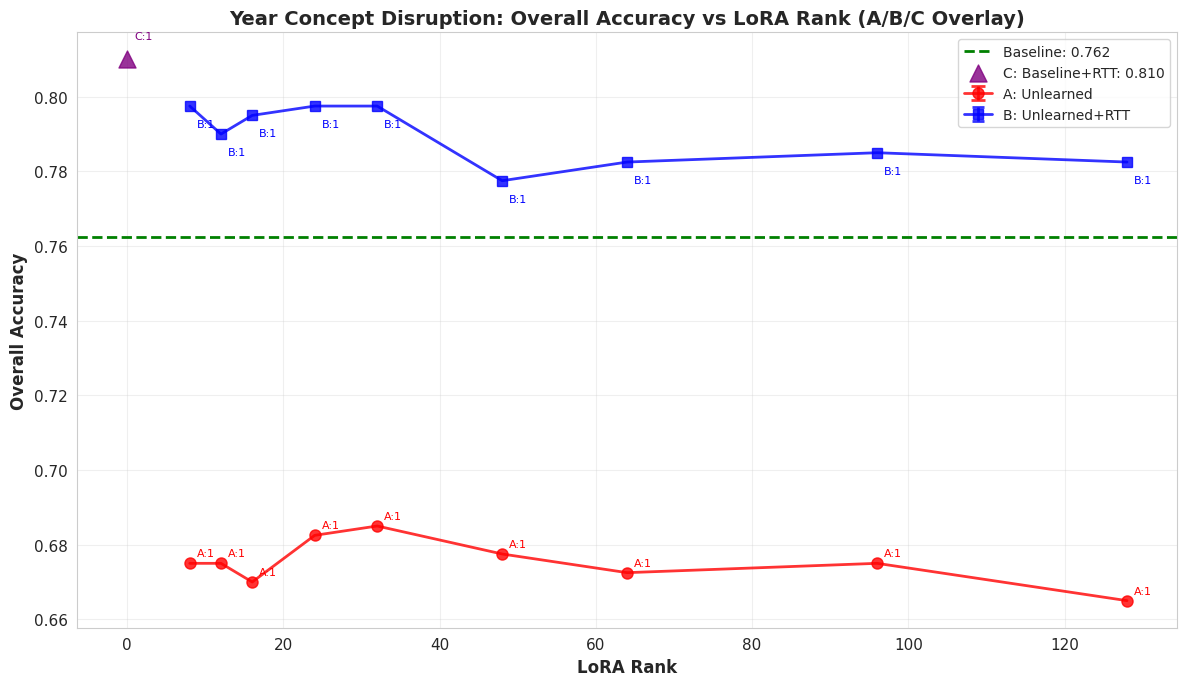

In [6]:
def plot_overall_disruption(df: pd.DataFrame, save_path: Optional[str] = None):
    """Plot overall accuracy vs LoRA rank with A, B, C models overlaid.
    
    Args:
        df: DataFrame with evaluation results (must have 'checkpoint_type' column)
        save_path: Optional path to save figure
    """
    if df.empty:
        print("No data to plot")
        return
        
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Separate by checkpoint type
    baseline = df[df['checkpoint_type'] == 'BASELINE']
    a_models = df[df['checkpoint_type'] == 'A'].copy()
    b_models = df[df['checkpoint_type'] == 'B'].copy()
    c_models = df[df['checkpoint_type'] == 'C'].copy()
    
    # Plot baseline
    if len(baseline) > 0:
        baseline_acc = baseline['overall_acc'].mean()
        ax.axhline(y=baseline_acc, color='green', linestyle='--', linewidth=2, 
                  label=f'Baseline: {baseline_acc:.3f}')
    
    # Plot type A models (unlearned)
    if len(a_models) > 0:
        rank_stats = a_models.groupby('lora_rank')['overall_acc'].agg(['mean', 'std', 'count'])
        ranks = rank_stats.index.values
        means = rank_stats['mean'].values
        stds = rank_stats['std'].values
        ax.errorbar(ranks, means, yerr=stds, marker='o', markersize=8, 
                   linewidth=2, capsize=5, capthick=2, color='red', 
                   label='A: Unlearned', alpha=0.8)
        for rank, mean, count in zip(ranks, means, rank_stats['count'].values):
            ax.annotate(f'A:{int(count)}', xy=(rank, mean), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8, color='red')
    
    # Plot type B models (unlearned + RTT) - overlay on same ranks
    if len(b_models) > 0:
        rank_stats = b_models.groupby('lora_rank')['overall_acc'].agg(['mean', 'std', 'count'])
        ranks = rank_stats.index.values
        means = rank_stats['mean'].values
        stds = rank_stats['std'].values
        ax.errorbar(ranks, means, yerr=stds, marker='s', markersize=7, 
                   linewidth=2, capsize=4, capthick=2, color='blue', 
                   label='B: Unlearned+RTT', alpha=0.8)
        for rank, mean, count in zip(ranks, means, rank_stats['count'].values):
            ax.annotate(f'B:{int(count)}', xy=(rank, mean), 
                       xytext=(5, -15), textcoords='offset points', fontsize=8, color='blue')
    
    # Plot type C models (baseline + RTT) - at rank 0
    if len(c_models) > 0:
        c_acc = c_models['overall_acc'].mean()
        ax.scatter([0], [c_acc], marker='^', s=150, color='purple', 
                  zorder=5, label=f'C: Baseline+RTT: {c_acc:.3f}', alpha=0.8)
        ax.annotate(f'C:{len(c_models)}', xy=(0, c_acc), 
                   xytext=(5, 15), textcoords='offset points', fontsize=8, color='purple')
    
    ax.set_xlabel('LoRA Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('Overall Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Year Concept Disruption: Overall Accuracy vs LoRA Rank (A/B/C Overlay)', 
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    
    plt.show()

if not df.empty:
    plot_overall_disruption(df, save_path=os.path.join(OUTPUT_DIR, 'overall_disruption.png'))


## 6. Per-Metric Breakdown


Saved figure to figures/year_concept/metric_breakdown.png


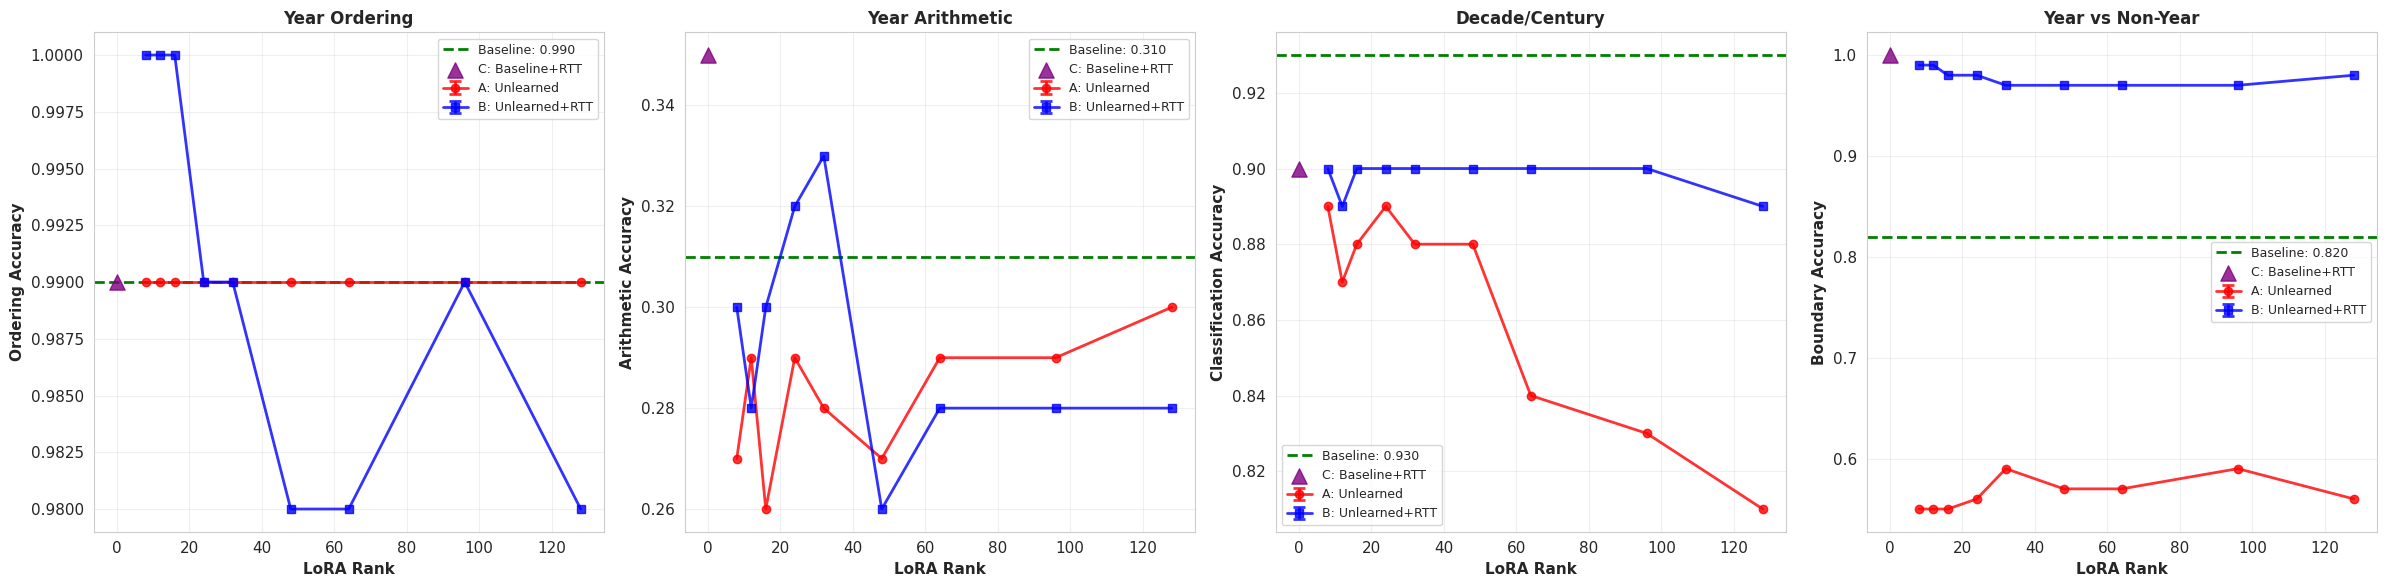

In [7]:
def plot_metric_breakdown(df: pd.DataFrame, save_path: Optional[str] = None):
    """Plot accuracy for each metric type with A, B, C models overlaid.
    
    Args:
        df: DataFrame with evaluation results (must have 'checkpoint_type' column)
        save_path: Optional path to save figure
    """
    if df.empty:
        print("No data to plot")
        return
        
    # Determine number of subplots (3 or 4 depending on boundary metric)
    has_boundary = 'boundary_acc' in df.columns
    num_plots = 4 if has_boundary else 3
    fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 6))
    if num_plots == 3:
        axes = [axes[0], axes[1], axes[2]]
    else:
        axes = [axes[0], axes[1], axes[2], axes[3]]
    
    metrics = [
        ('ordering_acc', 'Ordering Accuracy', 'Year Ordering'),
        ('arithmetic_acc', 'Arithmetic Accuracy', 'Year Arithmetic'),
        ('classification_acc', 'Classification Accuracy', 'Decade/Century')
    ]
    if has_boundary:
        metrics.append(('boundary_acc', 'Boundary Accuracy', 'Year vs Non-Year'))
    
    # Separate by checkpoint type
    baseline = df[df['checkpoint_type'] == 'BASELINE']
    a_models = df[df['checkpoint_type'] == 'A'].copy()
    b_models = df[df['checkpoint_type'] == 'B'].copy()
    c_models = df[df['checkpoint_type'] == 'C'].copy()
    
    for idx, (metric_col, ylabel, title) in enumerate(metrics):
        ax = axes[idx]
        
        # Plot baseline
        if len(baseline) > 0:
            baseline_acc = baseline[metric_col].mean()
            ax.axhline(y=baseline_acc, color='green', linestyle='--', linewidth=2, 
                     label=f'Baseline: {baseline_acc:.3f}')
        
        # Plot type A models
        if len(a_models) > 0:
            rank_stats = a_models.groupby('lora_rank')[metric_col].agg(['mean', 'std'])
            ranks = rank_stats.index.values
            means = rank_stats['mean'].values
            stds = rank_stats['std'].values
            ax.errorbar(ranks, means, yerr=stds, marker='o', markersize=6, 
                      linewidth=2, capsize=4, capthick=2, color='red', 
                      label='A: Unlearned', alpha=0.8)
        
        # Plot type B models
        if len(b_models) > 0:
            rank_stats = b_models.groupby('lora_rank')[metric_col].agg(['mean', 'std'])
            ranks = rank_stats.index.values
            means = rank_stats['mean'].values
            stds = rank_stats['std'].values
            ax.errorbar(ranks, means, yerr=stds, marker='s', markersize=6, 
                      linewidth=2, capsize=4, capthick=2, color='blue', 
                      label='B: Unlearned+RTT', alpha=0.8)
        
        # Plot type C models (at rank 0)
        if len(c_models) > 0:
            c_acc = c_models[metric_col].mean()
            ax.scatter([0], [c_acc], marker='^', s=120, color='purple', 
                      zorder=5, label=f'C: Baseline+RTT', alpha=0.8)
        
        ax.set_xlabel('LoRA Rank', fontsize=11, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    
    plt.show()

if not df.empty:
    plot_metric_breakdown(df, save_path=os.path.join(OUTPUT_DIR, 'metric_breakdown.png'))


## 7. Disruption Magnitude Analysis


Saved figure to figures/year_concept/disruption_magnitude.png


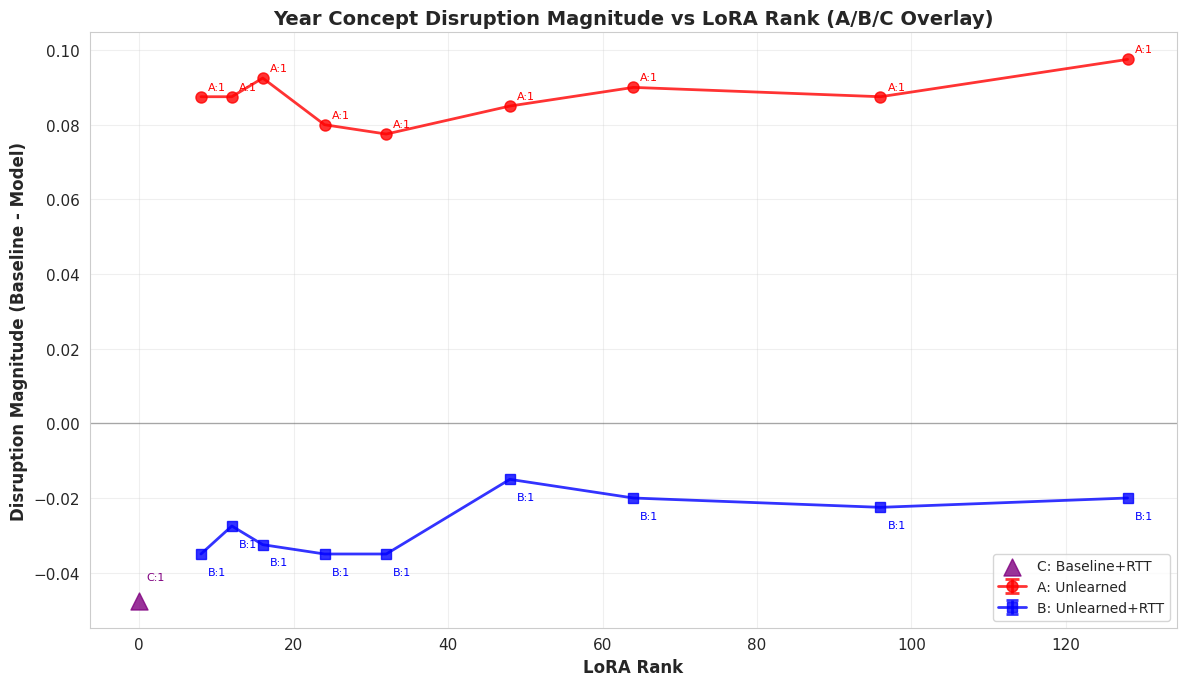


=== Disruption Summary ===
Baseline accuracy: 0.7625

A (Unlearned) disruption by LoRA rank:
  Rank 16: +0.0925
  Rank 32: +0.0775
  Rank 64: +0.0900
  Rank 8: +0.0875
  Rank 128: +0.0975
  Rank 12: +0.0875
  Rank 48: +0.0850
  Rank 96: +0.0875
  Rank 24: +0.0800

B (Unlearned+RTT) disruption by LoRA rank:
  Rank 32: -0.0350
  Rank 64: -0.0200
  Rank 16: -0.0325
  Rank 128: -0.0200
  Rank 8: -0.0350
  Rank 96: -0.0225
  Rank 12: -0.0275
  Rank 48: -0.0150
  Rank 24: -0.0350

C (Baseline+RTT) disruption: -0.0475


In [8]:
def plot_disruption_magnitude(df: pd.DataFrame, save_path: Optional[str] = None):
    """Plot disruption magnitude (baseline - model) vs LoRA rank for A, B, C models.
    
    Args:
        df: DataFrame with evaluation results (must have 'checkpoint_type' column)
        save_path: Optional path to save figure
    """
    if df.empty:
        print("No data to plot")
        return
        
    baseline = df[df['checkpoint_type'] == 'BASELINE']
    a_models = df[df['checkpoint_type'] == 'A'].copy()
    b_models = df[df['checkpoint_type'] == 'B'].copy()
    c_models = df[df['checkpoint_type'] == 'C'].copy()
    
    if len(baseline) == 0:
        print("Need baseline model to compute disruption")
        return
    
    baseline_acc = baseline['overall_acc'].mean()
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Compute and plot disruption for type A models
    if len(a_models) > 0:
        a_models = a_models.copy()
        a_models['disruption'] = baseline_acc - a_models['overall_acc']
        rank_stats = a_models.groupby('lora_rank')['disruption'].agg(['mean', 'std', 'count'])
        ranks = rank_stats.index.values
        means = rank_stats['mean'].values
        stds = rank_stats['std'].values
        ax.errorbar(ranks, means, yerr=stds, marker='o', markersize=8, 
                   linewidth=2, capsize=5, capthick=2, color='red', 
                   label='A: Unlearned', alpha=0.8)
        for rank, mean, count in zip(ranks, means, rank_stats['count'].values):
            ax.annotate(f'A:{int(count)}', xy=(rank, mean), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8, color='red')
    
    # Compute and plot disruption for type B models
    if len(b_models) > 0:
        b_models = b_models.copy()
        b_models['disruption'] = baseline_acc - b_models['overall_acc']
        rank_stats = b_models.groupby('lora_rank')['disruption'].agg(['mean', 'std', 'count'])
        ranks = rank_stats.index.values
        means = rank_stats['mean'].values
        stds = rank_stats['std'].values
        ax.errorbar(ranks, means, yerr=stds, marker='s', markersize=7, 
                   linewidth=2, capsize=4, capthick=2, color='blue', 
                   label='B: Unlearned+RTT', alpha=0.8)
        for rank, mean, count in zip(ranks, means, rank_stats['count'].values):
            ax.annotate(f'B:{int(count)}', xy=(rank, mean), 
                       xytext=(5, -15), textcoords='offset points', fontsize=8, color='blue')
    
    # Compute and plot disruption for type C models (at rank 0)
    if len(c_models) > 0:
        c_disruption = baseline_acc - c_models['overall_acc'].mean()
        ax.scatter([0], [c_disruption], marker='^', s=150, color='purple', 
                  zorder=5, label=f'C: Baseline+RTT', alpha=0.8)
        ax.annotate(f'C:{len(c_models)}', xy=(0, c_disruption), 
                   xytext=(5, 15), textcoords='offset points', fontsize=8, color='purple')
    
    # Add zero line
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    
    ax.set_xlabel('LoRA Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('Disruption Magnitude (Baseline - Model)', fontsize=12, fontweight='bold')
    ax.set_title('Year Concept Disruption Magnitude vs LoRA Rank (A/B/C Overlay)', 
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    
    plt.show()
    
    # Print summary
    print("\n=== Disruption Summary ===")
    print(f"Baseline accuracy: {baseline_acc:.4f}")
    if len(a_models) > 0:
        print("\nA (Unlearned) disruption by LoRA rank:")
        for rank in a_models['lora_rank'].unique():
            rank_data = a_models[a_models['lora_rank'] == rank]
            mean_disruption = rank_data['disruption'].mean()
            print(f"  Rank {rank}: {mean_disruption:+.4f}")
    if len(b_models) > 0:
        print("\nB (Unlearned+RTT) disruption by LoRA rank:")
        for rank in b_models['lora_rank'].unique():
            rank_data = b_models[b_models['lora_rank'] == rank]
            mean_disruption = rank_data['disruption'].mean()
            print(f"  Rank {rank}: {mean_disruption:+.4f}")
    if len(c_models) > 0:
        c_disruption = baseline_acc - c_models['overall_acc'].mean()
        print(f"\nC (Baseline+RTT) disruption: {c_disruption:+.4f}")

if not df.empty:
    plot_disruption_magnitude(df, save_path=os.path.join(OUTPUT_DIR, 'disruption_magnitude.png'))


## 8. Correlation Analysis



Saved figure to figures/year_concept/correlation_analysis.png


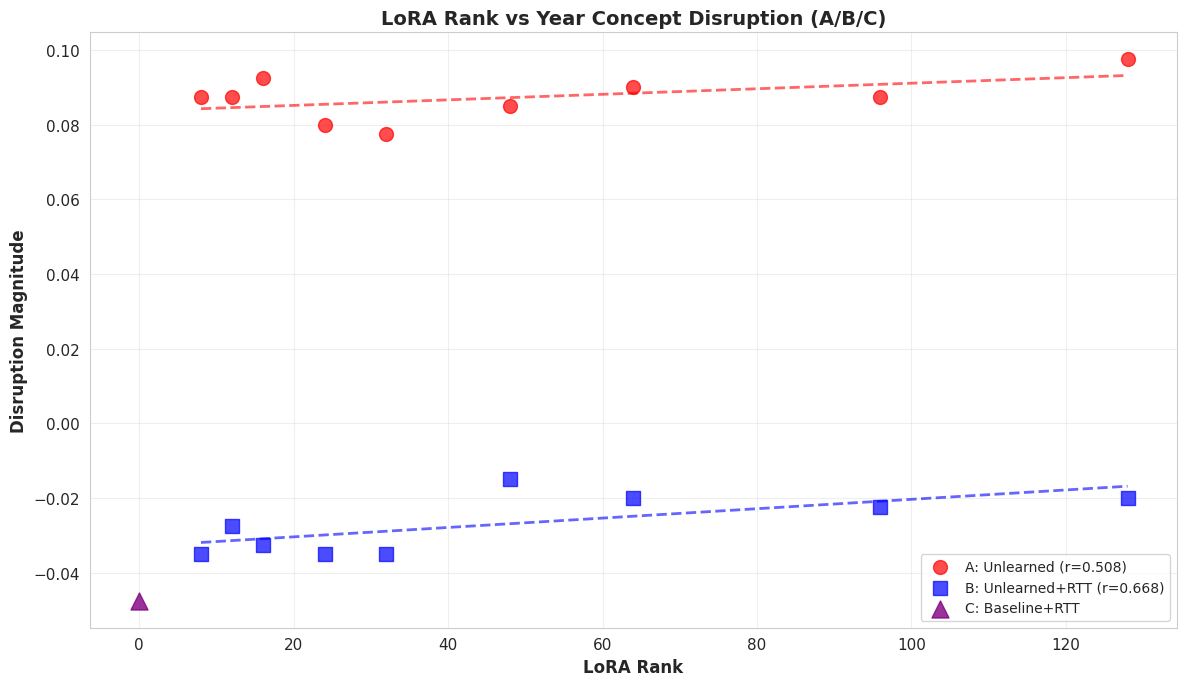


=== Correlation Analysis ===
A (Unlearned): r = 0.5083
  → Strong correlation
B (Unlearned+RTT): r = 0.6681
  → Strong correlation


In [9]:
def analyze_correlation(df: pd.DataFrame):
    """Analyze correlation between LoRA rank and disruption for A, B, C models.
    
    Args:
        df: DataFrame with evaluation results (must have 'checkpoint_type' column)
    """
    if df.empty:
        print("No data to analyze")
        return
        
    baseline = df[df['checkpoint_type'] == 'BASELINE']
    a_models = df[df['checkpoint_type'] == 'A'].copy()
    b_models = df[df['checkpoint_type'] == 'B'].copy()
    c_models = df[df['checkpoint_type'] == 'C'].copy()
    
    if len(baseline) == 0:
        print("Need baseline model")
        return
    
    baseline_acc = baseline['overall_acc'].mean()
    
    # Scatter plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot type A models
    if len(a_models) > 0:
        a_models = a_models.copy()
        a_models['disruption'] = baseline_acc - a_models['overall_acc']
        correlation_a = a_models['lora_rank'].corr(a_models['disruption'])
        ax.scatter(a_models['lora_rank'], a_models['disruption'], 
                  alpha=0.7, s=100, color='red', marker='o', label=f'A: Unlearned (r={correlation_a:.3f})')
        if len(a_models) > 1:
            z = np.polyfit(a_models['lora_rank'], a_models['disruption'], 1)
            p = np.poly1d(z)
            rank_range = np.linspace(a_models['lora_rank'].min(), a_models['lora_rank'].max(), 100)
            ax.plot(rank_range, p(rank_range), "r--", linewidth=2, alpha=0.6)
    
    # Plot type B models
    if len(b_models) > 0:
        b_models = b_models.copy()
        b_models['disruption'] = baseline_acc - b_models['overall_acc']
        correlation_b = b_models['lora_rank'].corr(b_models['disruption'])
        ax.scatter(b_models['lora_rank'], b_models['disruption'], 
                  alpha=0.7, s=100, color='blue', marker='s', label=f'B: Unlearned+RTT (r={correlation_b:.3f})')
        if len(b_models) > 1:
            z = np.polyfit(b_models['lora_rank'], b_models['disruption'], 1)
            p = np.poly1d(z)
            rank_range = np.linspace(b_models['lora_rank'].min(), b_models['lora_rank'].max(), 100)
            ax.plot(rank_range, p(rank_range), "b--", linewidth=2, alpha=0.6)
    
    # Plot type C models (at rank 0)
    if len(c_models) > 0:
        c_disruption = baseline_acc - c_models['overall_acc'].mean()
        ax.scatter([0], [c_disruption], s=150, color='purple', marker='^', 
                  zorder=5, label='C: Baseline+RTT', alpha=0.8)
    
    ax.set_xlabel('LoRA Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('Disruption Magnitude', fontsize=12, fontweight='bold')
    ax.set_title('LoRA Rank vs Year Concept Disruption (A/B/C)', 
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    save_path = os.path.join(OUTPUT_DIR, 'correlation_analysis.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved figure to {save_path}")
    
    plt.show()
    
    # Print correlations
    print("\n=== Correlation Analysis ===")
    if len(a_models) > 0:
        correlation_a = a_models['lora_rank'].corr(a_models['disruption'])
        print(f"A (Unlearned): r = {correlation_a:.4f}")
        if abs(correlation_a) < 0.1:
            print("  → Weak correlation")
        elif abs(correlation_a) < 0.5:
            print("  → Moderate correlation")
        else:
            print("  → Strong correlation")
    if len(b_models) > 0:
        correlation_b = b_models['lora_rank'].corr(b_models['disruption'])
        print(f"B (Unlearned+RTT): r = {correlation_b:.4f}")
        if abs(correlation_b) < 0.1:
            print("  → Weak correlation")
        elif abs(correlation_b) < 0.5:
            print("  → Moderate correlation")
        else:
            print("  → Strong correlation")

if not df.empty:
    analyze_correlation(df)


In [10]:
def create_summary_table(df: pd.DataFrame) -> pd.DataFrame:
    """Create summary table with key statistics.
    
    Args:
        df: DataFrame with evaluation results (should have 'checkpoint_type' column)
    
    Returns:
        Summary DataFrame
    """
    if df.empty:
        return pd.DataFrame()
    
    # Use checkpoint_type if available, otherwise fall back to lora_rank
    if 'checkpoint_type' in df.columns:
        baseline = df[df['checkpoint_type'] == 'BASELINE']
        a_models = df[df['checkpoint_type'] == 'A'].copy()
    else:
        # Fallback for old CSV files
        baseline = df[df['lora_rank'] == 0]
        a_models = df[df['lora_rank'] > 0].copy()
    
    if len(baseline) == 0:
        print("No baseline models found")
        return pd.DataFrame()
    
    baseline_acc = baseline['overall_acc'].mean()
    
    if len(a_models) > 0:
        a_models = a_models.copy()
        a_models['disruption'] = baseline_acc - a_models['overall_acc']
        
        # Build aggregation dict - include boundary if available
        agg_dict = {
            'overall_acc': ['mean', 'std', 'count'],
            'ordering_acc': 'mean',
            'arithmetic_acc': 'mean',
            'classification_acc': 'mean',
            'disruption': ['mean', 'std']
        }
        if 'boundary_acc' in a_models.columns:
            agg_dict['boundary_acc'] = 'mean'
        
        summary = a_models.groupby('lora_rank').agg(agg_dict).round(4)
        
        # Flatten column names
        summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
        
        # Add baseline row
        baseline_row_dict = {
            'overall_acc_mean': [baseline_acc],
            'overall_acc_std': [baseline['overall_acc'].std()],
            'overall_acc_count': [len(baseline)],
            'ordering_acc_mean': [baseline['ordering_acc'].mean()],
            'arithmetic_acc_mean': [baseline['arithmetic_acc'].mean()],
            'classification_acc_mean': [baseline['classification_acc'].mean()],
            'disruption_mean': [0.0],
            'disruption_std': [0.0]
        }
        if 'boundary_acc' in baseline.columns:
            baseline_row_dict['boundary_acc_mean'] = [baseline['boundary_acc'].mean()]
        
        baseline_row = pd.DataFrame(baseline_row_dict, index=[0])
        
        summary = pd.concat([baseline_row, summary]).sort_index()
        summary.index.name = 'LoRA Rank'
        
        return summary
    else:
        return pd.DataFrame()

if not df.empty:
    summary_table = create_summary_table(df)
    if not summary_table.empty:
        print("\n=== Summary Table ===")
        display(summary_table)
        
        # Save to CSV
        summary_path = os.path.join(OUTPUT_DIR, 'summary_table.csv')
        summary_table.to_csv(summary_path)
        print(f"\nSaved summary table to {summary_path}")



=== Summary Table ===


,overall_acc_mean,overall_acc_std,overall_acc_count,ordering_acc_mean,arithmetic_acc_mean,classification_acc_mean,disruption_mean,disruption_std,boundary_acc_mean
LoRA Rank,,,,,,,,,
0,0.7625,NaN,1,0.99,0.31,0.93,0.0000,0.0,0.82
8,0.6750,NaN,1,0.99,0.27,0.89,0.0875,NaN,0.55
12,0.6750,NaN,1,0.99,0.29,0.87,0.0875,NaN,0.55
16,0.6700,NaN,1,0.99,0.26,0.88,0.0925,NaN,0.55
24,0.6825,NaN,1,0.99,0.29,0.89,0.0800,NaN,0.56
32,0.6850,NaN,1,0.99,0.28,0.88,0.0775,NaN,0.59
48,0.6775,NaN,1,0.99,0.27,0.88,0.0850,NaN,0.57
64,0.6725,NaN,1,0.99,0.29,0.84,0.0900,NaN,0.57
96,0.6750,NaN,1,0.99,0.29,0.83,0.0875,NaN,0.59



Saved summary table to figures/year_concept/summary_table.csv
